In [2]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


# Autocodificadores

Fazer um jupyter notebook com autocodificador, a exemplo do exemplo mostrado em aula usando o Keras:

- https://t-adessowiki.fee.unicamp.br/user/aluno/notebooks/ia368z_2s2017/ia368z/deliver-keras/DenseAutoencoder.ipynb

Com as seguintes modificações:

- Utilizar o PyTorch
- Se possível, utilizar um autocodificador convolucional, porém não é imperativo
- Uma vez que o autocodificador seja treinado e o espaço bidimensional seja mostrado dos códigos dos dígitos da base de dados NMIST, gerar novas imagens:
  - mostrar algumas imagens em pontos quaisquer neste espaço bidimensional
  - dados dois pontos neste espaço, mostrar várias imagens, começando no ponto 1 e caminhando numa reta que une os dois pontos, gerar imagens associadas a pontos igualmente espaçados nessa reta, até chegar ao segundo ponto. É se esperar que os números gerados sejam interpolados entre eles.

In [3]:
import numpy as np
from PIL import Image
from IPython import display
%matplotlib inline


In [4]:
import torch as tc
import torchvision
import torch.optim as optim

import torchvision.transforms as transforms
from torch.autograd import Variable


In [5]:
import torch

In [6]:
import time
import copy
import os
import sys
from copy import deepcopy

In [7]:
use_gpu = torch.cuda.is_available()

print(use_gpu)

False


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [8]:
data_train = torchvision.datasets.MNIST('/data/datasets/mnist_pytorch/', train=True)
data_test  = torchvision.datasets.MNIST('/data/datasets/mnist_pytorch/', train=False)

#data_train = torchvision.datasets.MNIST('../datasets/mnist_pytorch/', train=True,transform = transforms.ToTensor())
#data_test  = torchvision.datasets.MNIST('../datasets/mnist_pytorch/', train=False,transform = transforms.ToTensor())

In [11]:
len(data_train), len(data_test)

(60000, 10000)

In [12]:
data_train.train_data.shape, data_test.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Treinando com pouquíssimos dados

In [13]:
if True:
    n_train_samples = 10000
    n_test_samples = 5000
    data_train.train_data = data_train.train_data[:n_train_samples]
    data_train.train_labels = data_train.train_labels[:n_train_samples]
    data_test.test_data   = data_test.test_data[:n_test_samples]
    data_test.test_labels = data_test.test_labels[:n_test_samples]

In [14]:
data_train.train_data.shape, data_test.test_data.shape

(torch.Size([10000, 28, 28]), torch.Size([5000, 28, 28]))

## Criando o dataloader 

### Criando o dicionário com os 2 valores

In [15]:
data = {}
data['X_train'] = data_train.train_data
data['X_test'] = data_train.train_labels
data['y_train'] = data_test.test_data
data['y_test'] = data_test.test_labels

data_sizes =[{x : len(data[x]) for x in ['X_train', 'X_test', 'y_train', 'y_test']}]


In [16]:
print(data_sizes)

[{'X_test': 10000, 'y_test': 5000, 'y_train': 5000, 'X_train': 10000}]


In [1]:
class mnist_loader(tc.utils.data.Dataset):
    def __init__(self, data, train=False, transform=None):
        """
        Args:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.data = data
        if train:
            self.images = self.data['X_train'].numpy()
            self.target = self.data['y_train']
        else:
            self.images = self.data['X_test'].numpy()
            self.target = self.data['y_test']
        
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.target[idx]
        #print('type image',type(image))
        #print(image.shape)
        #mage = Image.fromarray(np.uint8(image.reshape(8, 28).transpose((1,2,0))), 'RGB')
        #Image = Image.fromarray(np.uint8(image.reshape(3, 32, 32).transpose((1,2,0))), 'RGB')

        image = Image.fromarray(np.uint8(image), 'L')
        
        if self.transform:
            image = self.transform(image)

        return image, target

NameError: name 'tc' is not defined

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

no_transform = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
mnist_redux_train = mnist_loader(data,train=True, transform=data_transforms['train'])


In [20]:
mnist_redux_test = mnist_loader(data,train=False, transform=data_transforms['test'])

In [21]:

train_loader = torch.utils.data.DataLoader(data_train, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=50, shuffle=False)

print('length of training dataloader', len(train_loader))
print('length of test dataloader', len(test_loader))



length of training dataloader 200
length of test dataloader 100


## Criando a rede com autoencoders

In [22]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()              
        
        self.input_dim = (28,28)
        self.dense1 = tc.nn.Linear(28*28,512)
        self.dense2 = tc.nn.Linear(512,128)
        self.encoded = tc.nn.Linear(128,2)
        # at this point the representation is 2-dimensional
        self.dense3 = tc.nn.Linear(2,128)
        self.dense4 = tc.nn.Linear(128,512)
        self.decoded = tc.nn.Linear(512,28*28)
        
        #self.flatten = view(a.numel())

    def forward(self, x):
        
        recon_x = x
        x = x.view(x.size(0), -1)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.encoded(x)
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
        x = self.decoded(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    

In [23]:
autoencoder = Net()
print(autoencoder)

Net (
  (dense1): Linear (784 -> 512)
  (dense2): Linear (512 -> 128)
  (encoded): Linear (128 -> 2)
  (dense3): Linear (2 -> 128)
  (dense4): Linear (128 -> 512)
  (decoded): Linear (512 -> 784)
)


In [ ]:
if use_gpu:
    autoencoder.cuda()

## Treinando o modelo

In [35]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [36]:
def train_model(model,dset_loaders, dset_sizes,
                criterion, optimizer, lr_scheduler,
                num_epochs=25, model_fn=None, reset=False):
    
    since = time.time()
    #print('here')
    if not reset and os.path.isfile(model_fn):
        #model.load_state_dict(tc.load(model_fn))
        print('Loading model %s' % model_fn)
        model = tc.load(model_fn)
    else:
        print('Build model from init')
    try:
        best_model = copy.deepcopy(model)
        best_epoch = 0
        best_acc = 0.0

        #print('here2')
        for epoch in range(num_epochs):
            start_epoch = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    optimizer = lr_scheduler(optimizer, epoch)
                    model.train(True)  # Set model to training mode
                else:
                    model.train(False)  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for k,data in enumerate(dset_loaders[phase]):
                    if k > 500:
                        break
                    sys.stdout.write('%d/%d mini-batch: %s\r' % (k,len(dset_loaders[phase]),phase))
                    # get the inputs
                    inputs, labels = data
                    #$inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    
                    # wrap them in Variable
                    if use_gpu:
                        #print('gpu')
                        inputs, labels = Variable(inputs.cuda()),Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                                        # zero the parameter gradients
                    input_x = inputs.view(-1, 28*28)   # batch x, shape (batch, 28*28)
                    input_y = inputs.view(-1, 28*28)   # batch y, shape (batch, 28*28)
                    #inputs_y = inputs
                    
                    #print(inputs.size())
                    
                    #outputs = model(input_x)
                    outputs = model(inputs).view(inputs.data.shape)    
                    preds = outputs.data
                    '''
                    loss = loss_func(decoded, b_y)      # mean square error
                    optimizer.zero_grad()               # clear gradients for this training step
                    loss.backward()                     # backpropagation, compute gradients
                    optimizer.step()
                    '''
                    #inputs = inputs.view(28*28)
                
                    #loss = criterion(outputs, inputs)
                    loss = tc.nn.MSELoss()(outputs,input_y)
                    optimizer.zero_grad()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                     #target = autograd.Variable(torch.LongTensor(3).random_(2))
                    #>>> loss = F.binary_cross_entropy(F.sigmoid(input), target)
                    
                    
                    # statistics
                    running_loss += loss.data[0]
                    #running_corrects += tc.sum(preds == labels.data)

                epoch_loss = running_loss / dset_sizes[phase]
                #epoch_acc = running_corrects / dset_sizes[phase]

                time_epoch = time.time() - start_epoch
               # print('{}({:.1f}s) Loss: {:.4f} Acc: {:.4f}'.format(phase, time_epoch, epoch_loss, epoch_acc))
                print('{}({:.1f}s) Loss: {:.4f}'.format(phase, time_epoch, epoch_loss))

               # # deep copy the model
                #if phase == 'val' and epoch_acc > best_acc:
                 #   best_acc = epoch_acc
                  #  best_epoch = epoch
                    #best_model = copy.deepcopy(model)

            print()
    except  KeyboardInterrupt:
        print('Interrupted!!')
    
    if model_fn:
        tc.save(best_model, model_fn)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at epoch: {}'.format(best_acc,best_epoch))
    return best_model

In [37]:
def train_2(model,data_loader,criterion,optimizer,num_epochs=25):
    
    since = time.time()
    
    for epoch in range(num_epochs):
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0

        # Iterate over data.
        for k,data in enumerate(data_loader):
            if k > 500:
                break
            sys.stdout.write('%d/%d mini-batch: \r' % (k,len(data_loader)))

            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            if use_gpu:
                #print('gpu')
                inputs, labels = Variable(inputs.cuda()),Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            #Reshape nas entradas
            input_x = inputs.view(-1, 28*28)   # batch x, shape (batch, 28*28)
            input_y = inputs.view(-1, 28*28)   # batch y, shape (batch, 28*28)

            #Decodifico com a minha rede autoencoder
            #output = model(inp).view(inp.data.shape)
            outputs=model(inputs).view(inputs.data.shape)
            #outputs = model(input_x)

            #Defino a função de perda
            loss = criterion(outputs, input_y)

            #Zero os valores dos gradients
            optimizer.zero_grad()

            #Propago o erro na função loss
            loss.backward()

            # Dá o passo do optimizer
            optimizer.step()



            # statistics
            running_loss += loss.data[0]

            epoch_loss = running_loss / len(data_loader)

            time_epoch = time.time() - start_epoch
          
        print('({:.1f}s) Loss: {:.4f}'.format(time_epoch, epoch_loss))
        print()
  #  except  KeyboardInterrupt:
   #     print('Interrupted!!')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return 0

In [38]:
LR = 0.005 
criterion = tc.nn.MSELoss(size_average=True)
optimizer_ft = optim.Adam(autoencoder.parameters(), lr=LR)


In [39]:
# Empty dict
new_dict = {}
# Fill in the entries one by one
new_dict["train"] = mnist_redux_train

new_dict['val'] = mnist_redux_test

In [40]:
new_dict_sizes = {x: len(new_dict[x]) for x in ['train', 'val']}
print(new_dict_sizes)

{'train': 5000, 'val': 5000}


In [41]:
a = torch.rand(2,3)
print('a sizea',a.size())

a sizea torch.Size([2, 3])


In [42]:
import sys
sys.executable
from datetime import datetime

In [43]:
tstart = datetime.now()

tend = datetime.now()
print ('Time spent',tend - tstart)

Time spent 0:00:00.000103


In [44]:
print('cda')

cda


In [140]:
tstart = datetime.now()

model_ft = train_model(autoencoder, new_dict,new_dict_sizes,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=45,
                       model_fn=None, 
                    reset=True)

tend = datetime.now()
print ('Time spent',tend - tstart)

Build model from init
Epoch 0/44
----------
LR is set to 0.001
train(1.3s) Loss: 0.0210in
val(1.3s) Loss: 0.0000

Epoch 1/44
----------
train(1.3s) Loss: 0.0207in
val(1.3s) Loss: 0.0000

Epoch 2/44
----------
train(1.3s) Loss: 0.0201in
val(1.3s) Loss: 0.0000

Epoch 3/44
----------
train(1.2s) Loss: 0.0201in
val(1.2s) Loss: 0.0000

Epoch 4/44
----------
train(1.2s) Loss: 0.0199in
val(1.2s) Loss: 0.0000

Epoch 5/44
----------
train(1.2s) Loss: 0.0198in
val(1.2s) Loss: 0.0000

Epoch 6/44
----------
train(1.2s) Loss: 0.0196in
val(1.2s) Loss: 0.0000

Epoch 7/44
----------
LR is set to 0.0001
train(1.2s) Loss: 0.0189in
val(1.2s) Loss: 0.0000

Epoch 8/44
----------
train(1.2s) Loss: 0.0185in
val(1.2s) Loss: 0.0000

Epoch 9/44
----------
train(1.1s) Loss: 0.0183in
val(1.1s) Loss: 0.0000

Epoch 10/44
----------
train(1.1s) Loss: 0.0182in
val(1.1s) Loss: 0.0000

Epoch 11/44
----------
train(1.2s) Loss: 0.0181in
val(1.2s) Loss: 0.0000

Epoch 12/44
----------
train(1.2s) Loss: 0.0181in
val(1.2s) L

tstart = datetime.now()


train_2(autoencoder,train_loader,criterion,optimizer_ft,num_epochs=25)

tend = datetime.now()
print ('Time spent',tend - tstart)

In [46]:
%matplotlib inline
import matplotlib.pyplot as plot

torch.Size([1, 28, 28])


ValueError: cannot copy sequence with size 28 to array axis with dimension 2

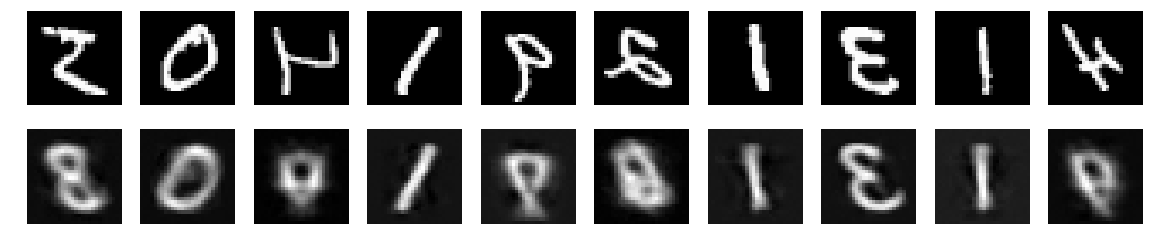

In [144]:
n = 10
plot.figure(figsize=(20, 4))
plot.gray()
lista = []
for k,data in enumerate(new_dict['train']):
 
    if k > 9:
        break
    inputs, labels = data

    #print('inputs size',inputs.size())
    autoencoder.train(True)
    if use_gpu:

        inputs, labels = Variable(inputs.cuda()),Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    #print(inputs.data.cpu().numpy().shape)
    #Reshape nas entradas
    input_x = inputs.view(-1, 28*28)   # batch x, shape (batch, 28*28)
    #input_y = inputs.view(-1, 28*28)   # batch y, shape (batch, 28*28)
    #outputs=autoencoder(input_x)
    outputs = autoencoder(inputs).view(inputs.data.shape)
    #outputs = autoencoder(inputs)
    lista.append(outputs.data.cpu().numpy())
    

    
    # display inputs
    ax = plot.subplot(2, n, k+1)
    plot.imshow(inputs.data.cpu().numpy().reshape(28, 28))
    plot.axis('off')

    # display reconstruction
    ax = plot.subplot(2, n, k+n+1)
    plot.imshow(outputs.data.cpu().numpy().reshape(28, 28))
    plot.axis('off')
    

## Mostra plot 2D das classes, no espaço codificado

In [65]:
encoder = tc.nn.Sequential(*list(autoencoder.children())[:-3])
encoder=encoder.cuda()
print(encoder)

Sequential (
  (0): Linear (784 -> 512)
  (1): Linear (512 -> 128)
  (2): Linear (128 -> 2)
)


In [154]:
vector=[]
vector_labels=[]
m=200
for k,data in enumerate(test_loader):
    if k<m:
        inputs,label = data
        i=0

        for inp,lab in zip(inputs,label):

            encoder.train(True)
            if use_gpu:
                inp_2 = Variable(inp.cuda())
                lab_2 = label

                #inp_2, lab_2 = Variable(inp.cuda()),Variable(lab.cuda())
            else:
                inp_2, lab_2 = Variable(inp), label

            #print(inputs.size())
            input_x = inp_2.view(-1, 28*28)  
            outputs = encoder(input_x)
            #outputs = encoder(inp_2).view(inp_2.data.shape)
            #print(outputs.size())
            #outputs = autoencoder(inputs)

            vector.append(outputs.data.cpu().numpy())

            vector_labels.append(lab_2.numpy()[i])

            i=i+1
            
print(len(vector))
print(len(vector_labels))

5000
5000


In [157]:
print(vector[0])

[-0.72086191  2.11378741]


In [155]:
vector=np.array(vector).reshape(len(vector),2)
vector_labels=np.array(vector_labels)
print(vector.shape)
print(vector_labels.shape)


(5000, 2)
(5000,)


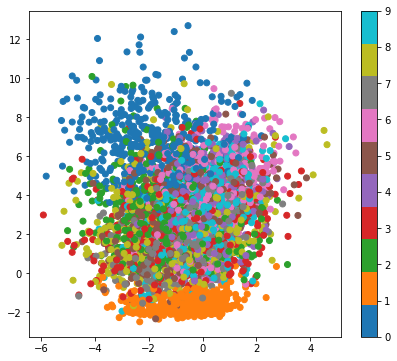

In [156]:

plot.figure(figsize=(7, 6))

plot.scatter(vector[:, 0], vector[:,1], c=vector_labels, cmap=plot.cm.tab10)

plot.colorbar();